# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import os
# Load pickled data
import pickle
import data_helpers as dh

# Base dir of the traffic signs
base_dir = "traffic-signs-data"

training_file = os.path.join(base_dir, "train.p")
validation_file = os.path.join(base_dir, "valid.p")
testing_file = os.path.join(base_dir, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train, return_counts=False))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

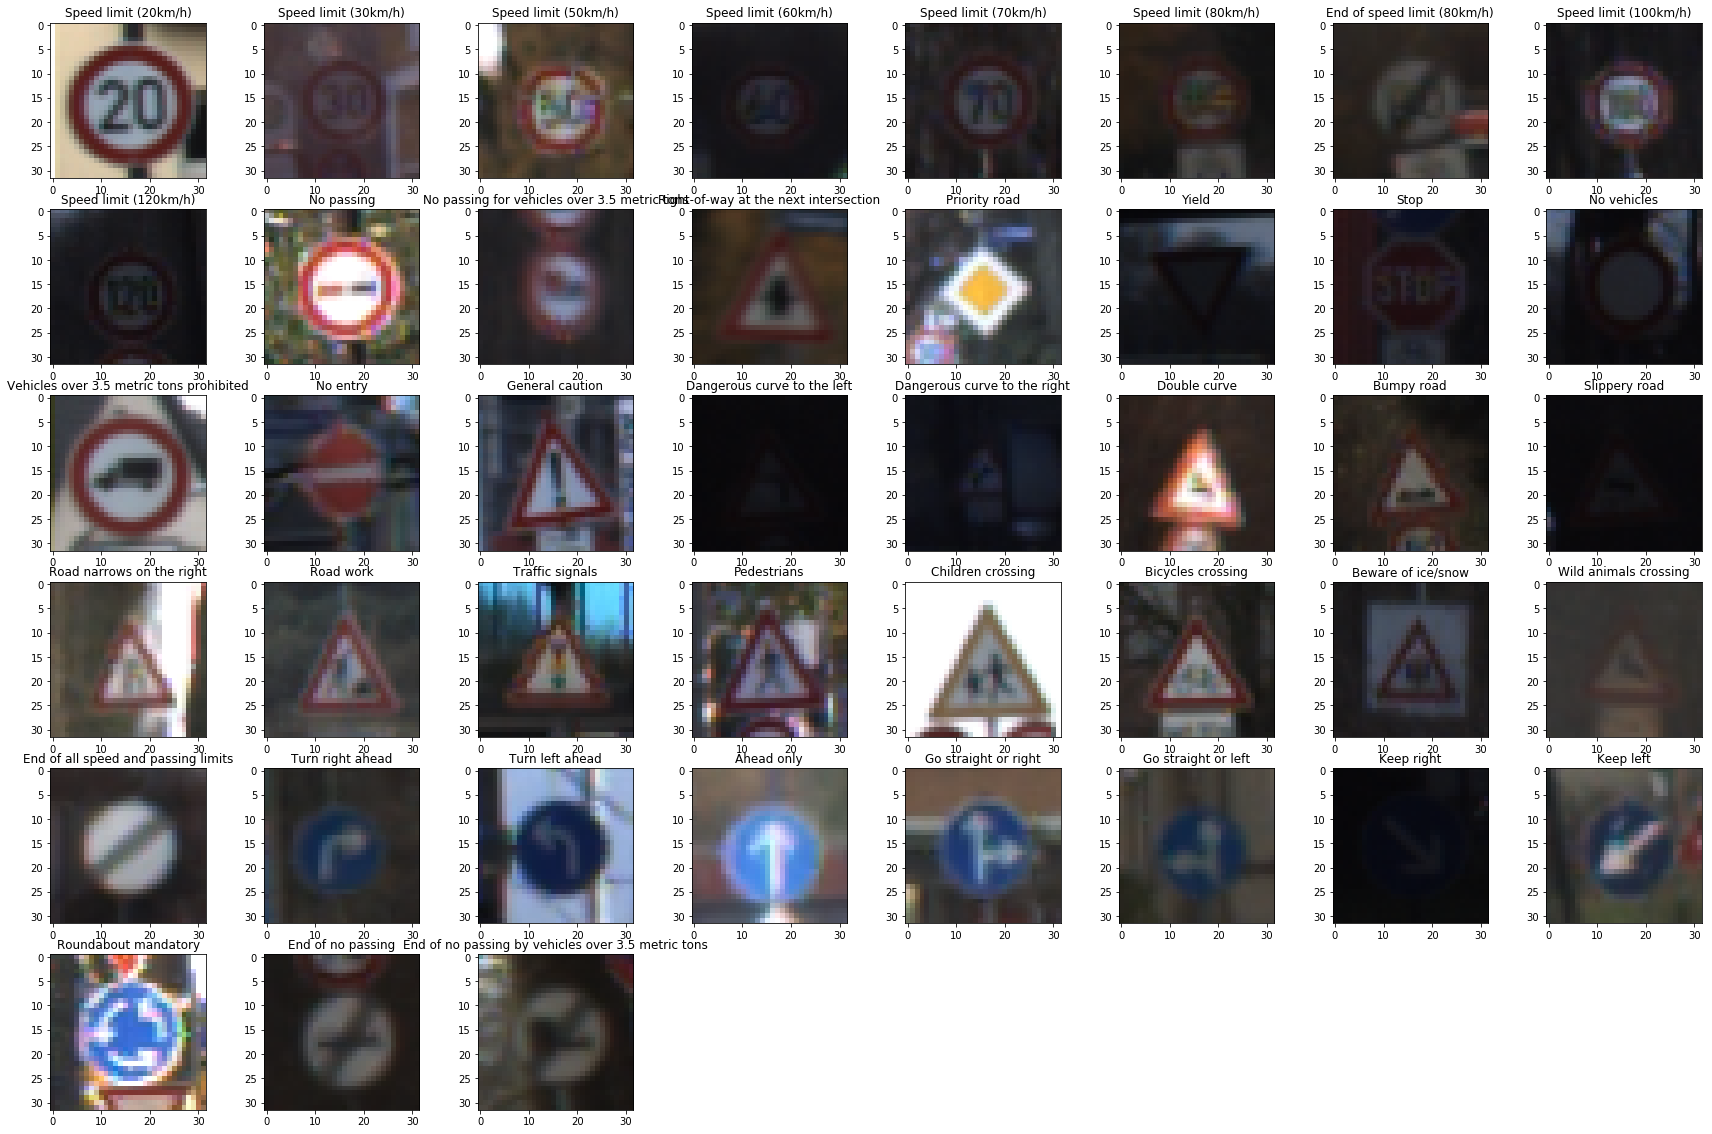

In [3]:
trafficsignmap = dh.create_trafficsign_map('signnames.csv')
def classid_to_trafficsign_name(classid):
    return trafficsignmap[classid]
    

# Displays the first traffic sign from each traffic-sign class, 43 images in total
import data_plotting as dplt
%matplotlib inline 

# group classes where Key is the class and Value is a list of indices used 
# to get the corresponding traffic sign from X_train

# This set contains the class ids of the traffic signs.
class_ids = list(set(y_train))

# A dictionary where Key is the class id and Value is a list of all indices to the traffic signs
# which belong to this class.
classes_dict = {}
    
for i in range(len(y_train)):
    key = y_train[i]
    classes_dict.setdefault(key, []).append(i)

# store the first image of every class in a list and show them
images = [X_train[indices[0]] for key,indices in classes_dict.items()]
    
dplt.set_plotsize(30,20)
dplt.showimages(images, class_ids, counts=43, rows=6, cols=8, isRandom=False, name='./examples/train_images', labelconverter=classid_to_trafficsign_name)

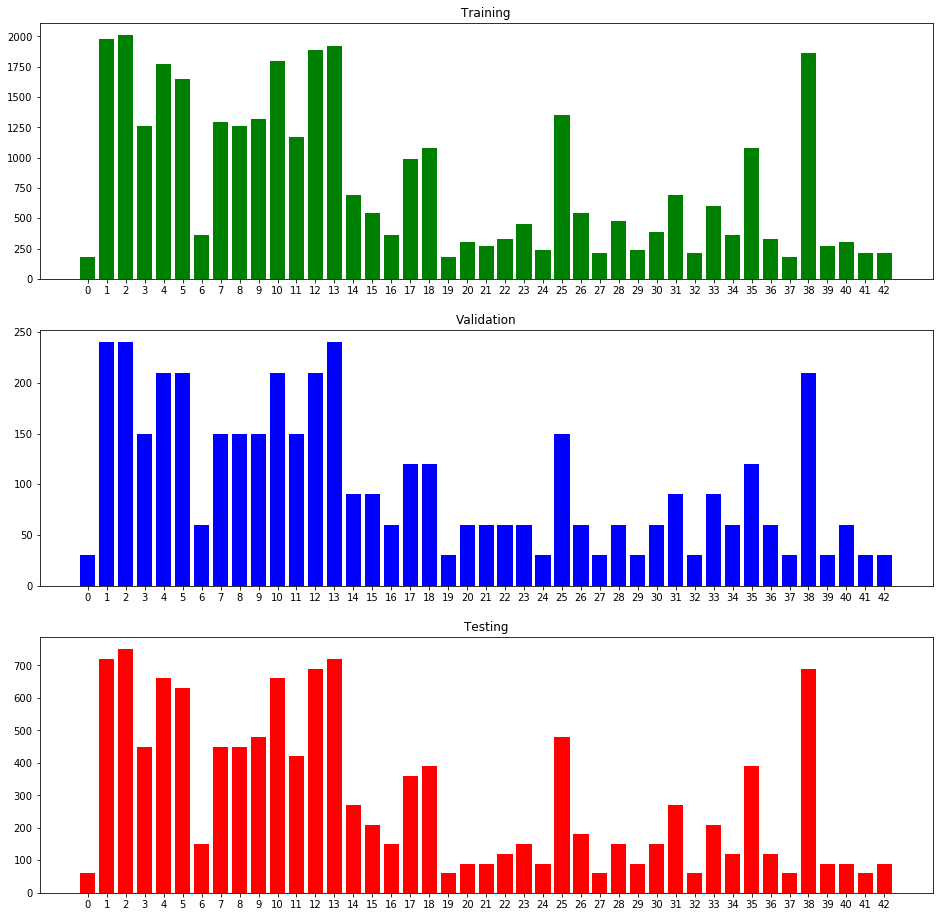

In [4]:
import numpy as np

# distribution of training,validation and test examples per class displayed as a histogram
dplt.set_plotsize(16,16)

train_labels, train_counts = np.unique(y_train, return_counts=True)
valid_labels, valid_counts = np.unique(y_valid, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)

dplt.histogram_traffic_signs([train_counts, valid_counts, test_counts], class_ids, name='./examples/traffic_sign_samples_distributions')

The histograms above show that the distriputions over the traffic sign classes in the three sets - training, validation and testing - are similar as well as  unbalanced. This could lead to biased predictions. One way to overcome this problem is to increase the samples of the underrepresented data by artificially augmenting them as it is shown below in Step 2 - Data Augmentation.

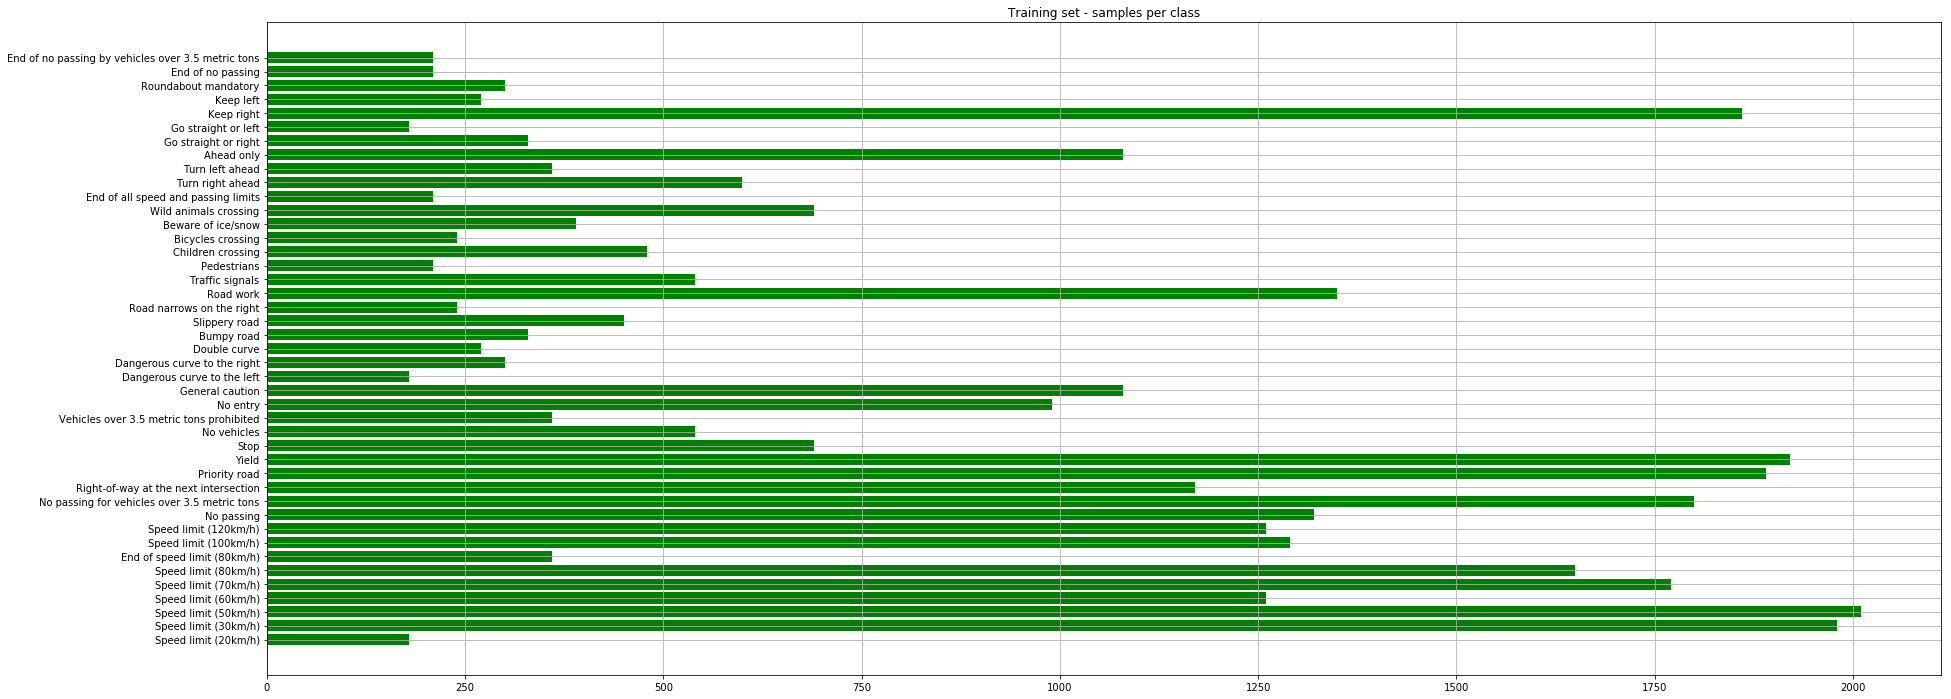

In [5]:
# Shows the number of samples per class of the training set as a horizontal barchart. The class ids are replaced with their
# traffic sign name
samples_per_class = {key : len(indices) for key,indices in classes_dict.items()}

dplt.set_plotsize(30,12)
dplt.barchart(samples_per_class.values(), class_ids, 'Training set - samples per class', name="./examples/training_set_samples_distribution")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Data Augmentation
The histogram above showed that data is unbalanced and that there are some traffic sign classes with less than 250 samples and others with more than 2000. Therefore different geometric transformations like translation, rotation and contrast adaptation are applied on the existing training samples to augment the number of training examples per traffic sign class. This approach is based on data augmentation methods mentioned in [http://www.people.usi.ch/mascij/data/papers/2011_ijcnn_committee.pdf] and [http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf]. The newly generated images are stored with their corresponding labels in a separate folder. Moreover, data generation is only executed once and only the training images will be augmented leaving the validation and test images untouched.

In [6]:
import numpy as np
import data_transformations as da
import data_helpers as dh

path = 'traffic-signs-data-augmented'
filename = 'augmented_training.p'

# + 120 because this is dividable by 3
max_samples = max(samples_per_class.values()) + 120

# check if augmented traffic signs file exists
file = os.path.join(path, filename)
if not os.path.isfile(file):
    
    augmented_images = []
    augmented_labels = []
    
    for key, num_samples in samples_per_class.items():
        if max_samples == num_samples:
            continue
        
        # get all images of this class
        indices = classes_dict[key]
        img_train = X_train[indices[0]:indices[num_samples-1]]
        
        new_samples_count = int((max_samples - num_samples) / 3)
        
        # Augment traffic sign class with different transformation parameters
        augmented_images.extend(da.deform_image(img_train, 10, 0, 0, None, new_samples_count))
        augmented_images.extend(da.deform_image(img_train, 10, 10, 0, [0.9, 1.0], new_samples_count))
        augmented_images.extend(da.deform_image(img_train, 10, 10, 30, [0.9, 1.0], new_samples_count))
        
        # Create label entries for this class
        class_labels = np.empty(new_samples_count * 3)
        class_labels.fill(key)
        augmented_labels.extend(class_labels)

    print("Images : {}, Labels : {}".format(len(augmented_images), len(augmented_labels)))
    
    assert(len(augmented_images) == len(augmented_labels))


    dh.persist(filename, augmented_images, augmented_labels)
else:
    print("Samples already generated")

Samples already generated


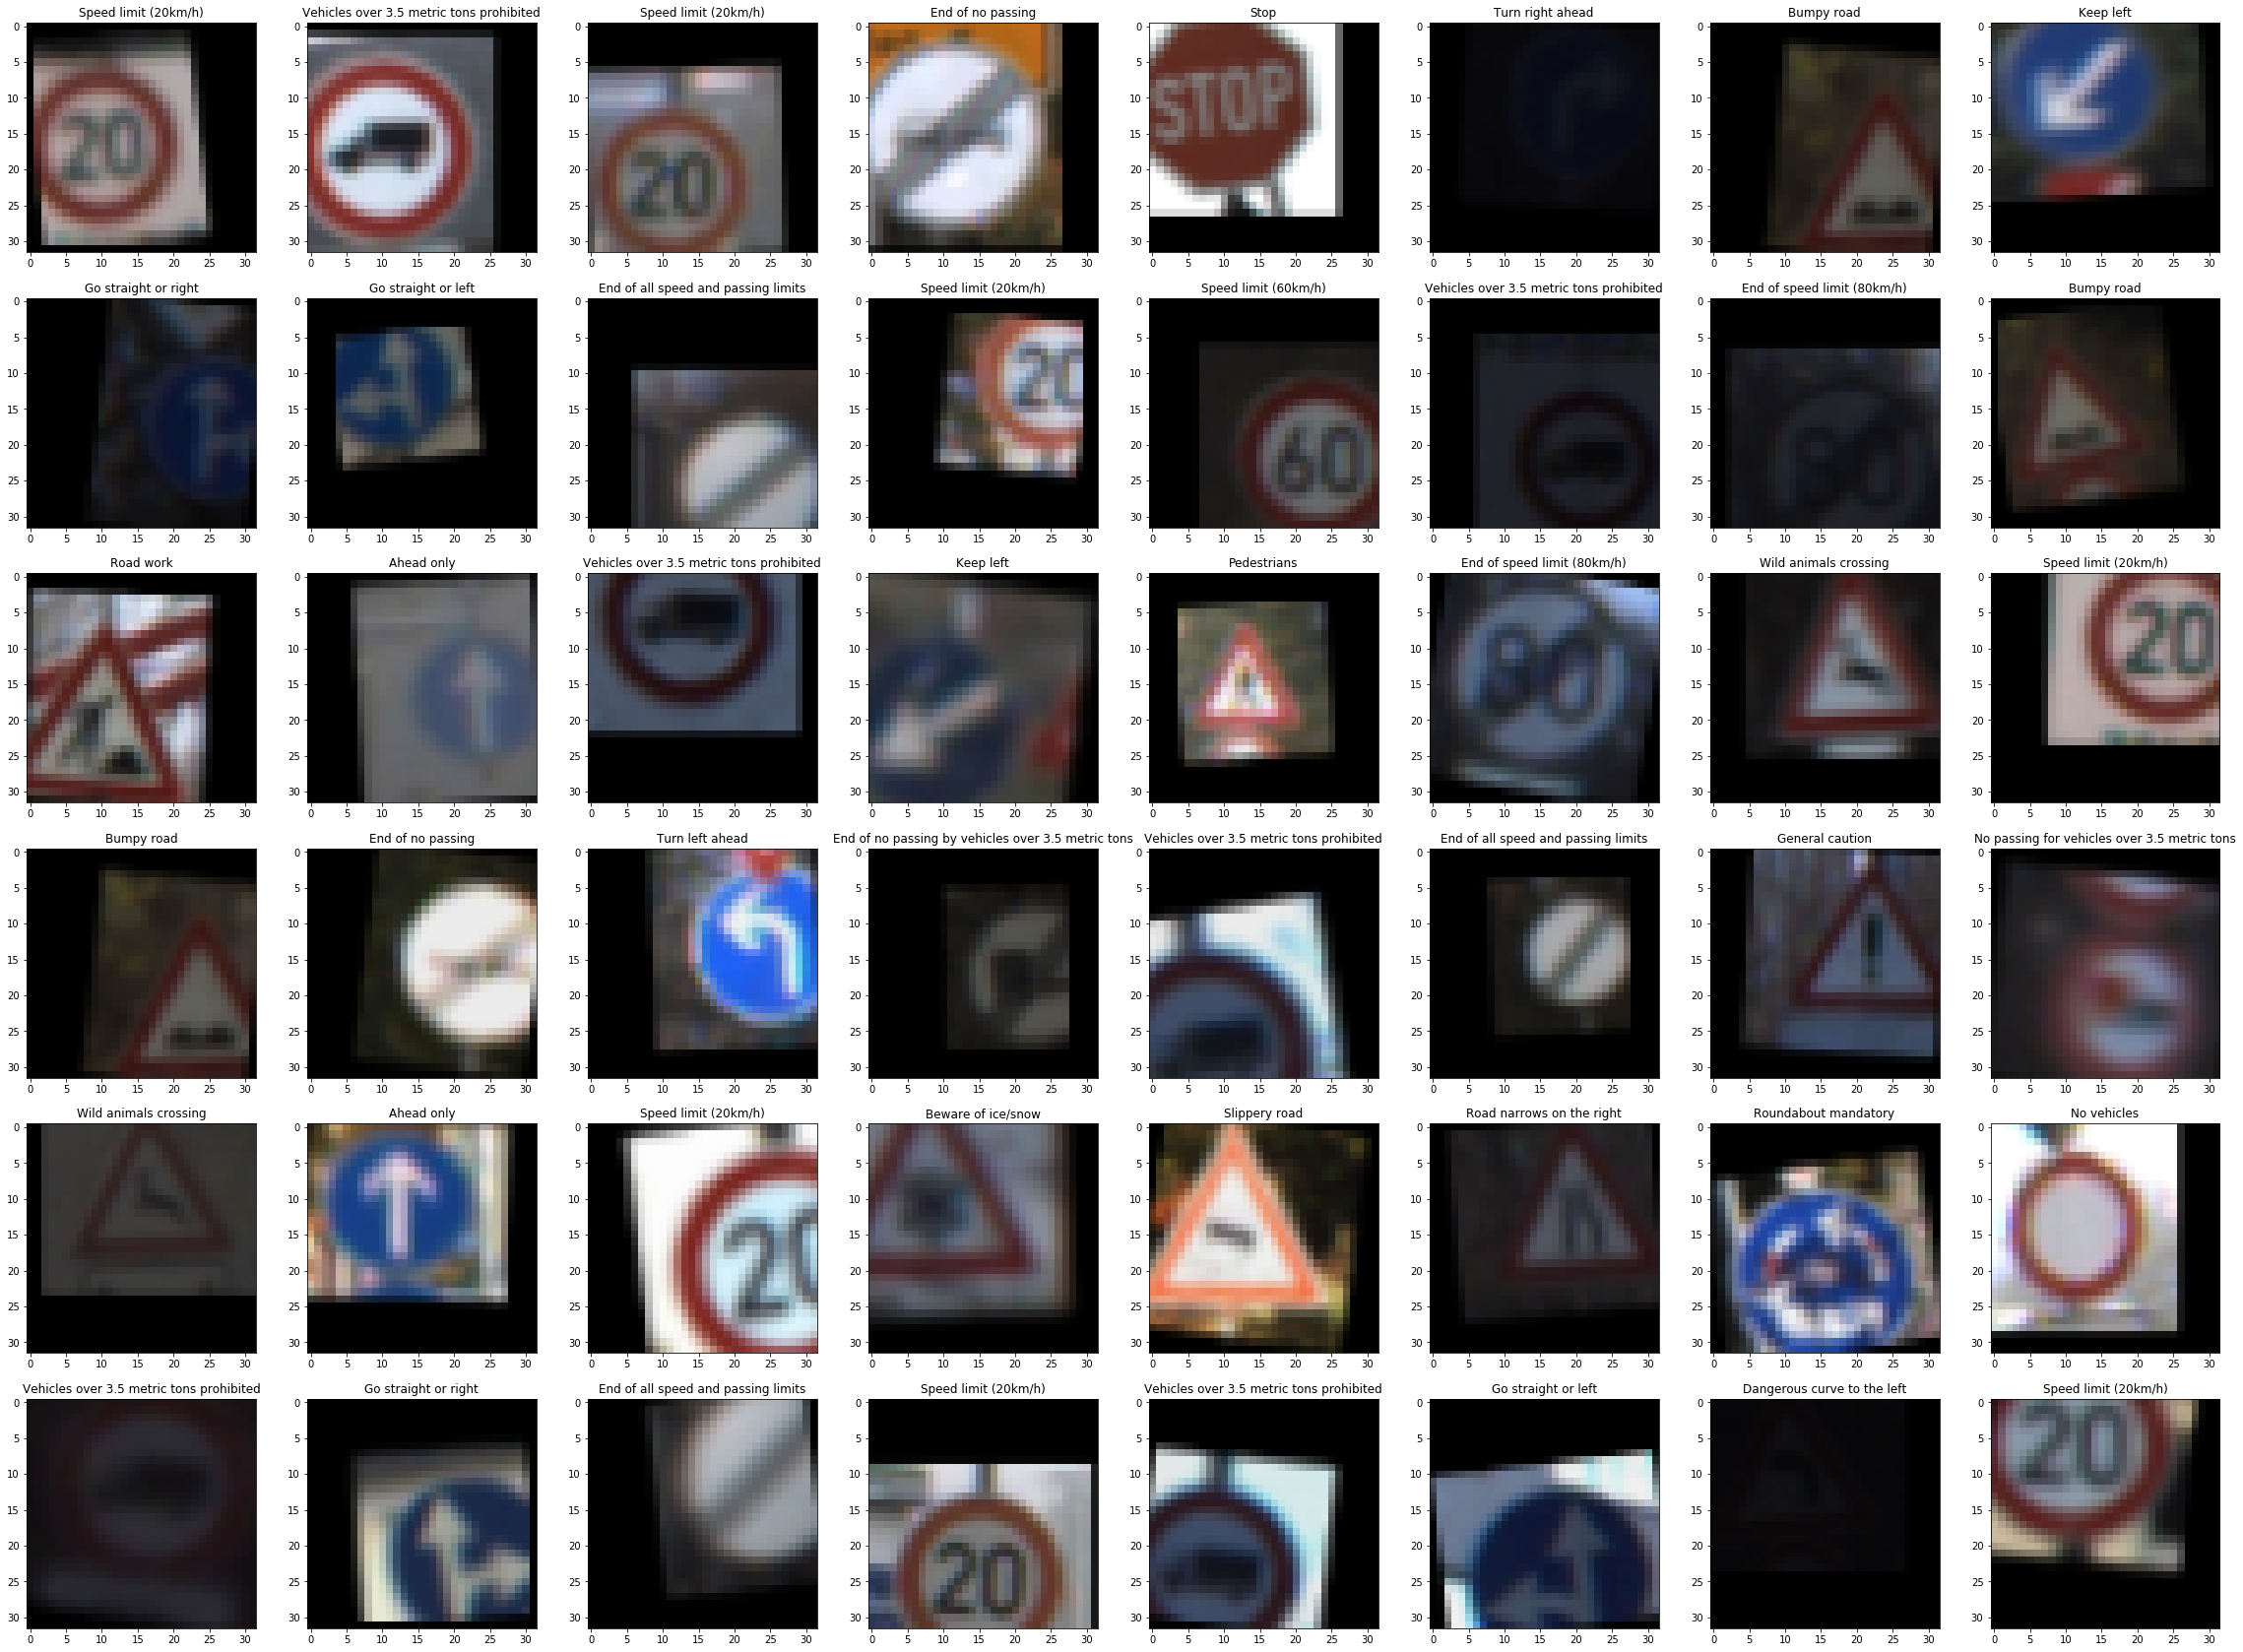

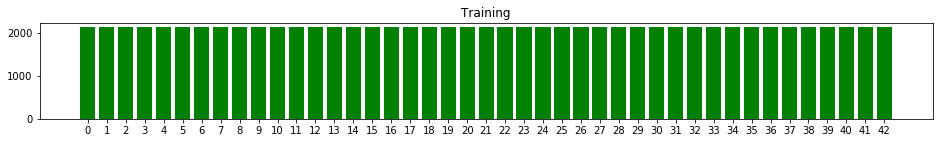

In [7]:
# Load augmented traffic signs and add them to the X_train data
persisted_data = dh.load(filename)
X_train_augmented = persisted_data['features']
y_train_augmented = persisted_data['labels']

# Plot randomly traffics signs
dplt.set_plotsize(40,30)
dplt.showimages(X_train_augmented, y_train_augmented, counts=48, rows=6, cols=8, isRandom=True, name="./examples/augmented_train_images", labelconverter=classid_to_trafficsign_name)

# Add augmented traffic signs to the original training set.
X_train = np.append(X_train, X_train_augmented, axis=0)
y_train = np.append(y_train, y_train_augmented, axis=0)

dplt.set_plotsize(16,6)

train_labels, train_counts = np.unique(y_train, return_counts=True)
dplt.histogram_traffic_signs([train_counts], class_ids, name="./examples/augmented_trainset_distribution")

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

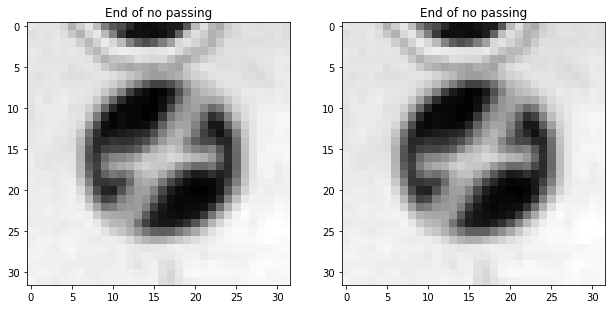

In [8]:
# Convert each image to grayscale
X_train_gray = [da.grayscale(image) for image in X_train]
X_valid_gray = [da.grayscale(image) for image in X_valid]

# Normalize images
X_train_normalized = [da.normalize(image) for image in X_train_gray]
X_valid_normalized = [da.normalize(image) for image in X_valid_gray]

# Reshape images
X_train_new = [da.expand(image) for image in X_train_normalized]
X_valid_new = [da.expand(image) for image in X_valid_normalized]

# show output of pre-processing methods
images = [X_train_gray[10], X_train_normalized[10]]
labels = [y_train[10], y_train[10]]

dplt.showimages(images, labels, counts=2, rows=1, cols=3, isRandom=False, isGray=True, labelconverter=classid_to_trafficsign_name)

### Model Architecture

In [9]:
# helper functions that are used to create a conv and pool layer
import tensorflow as tf

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

def conv_layer(x, w_shape, b_size, layername, stride = [1, 1, 1, 1], mu = 0.0, sigma = 0.1, pad = 'VALID'):
    with tf.name_scope(layername):
        with tf.name_scope("weights"):
            conv_W = tf.Variable(tf.truncated_normal(shape = w_shape, mean = mu, stddev = sigma))
            variable_summaries(conv_W)
        with tf.name_scope("biases"):
            conv_b = tf.Variable(tf.zeros(b_size))
            variable_summaries(conv_b)

        conv   = tf.nn.conv2d(x, conv_W, strides = stride, padding=pad) + conv_b
        conv   = tf.nn.relu(conv)
        
        return conv

def pool_layer(conv, kernel, stride, layername, pad = 'VALID'):
    with tf.name_scope(layername):
        conv = tf.nn.max_pool(conv, ksize = kernel, strides = stride, padding = pad)
        return conv
    
def fc_layer(x, w_shape, b_size, layername, mu = 0.0, sigma = 0.1, keep_prob = 1.0):
    with tf.name_scope(layername):
        with tf.name_scope("weights"):
            fc_W = tf.Variable(tf.truncated_normal(shape=w_shape, mean = mu, stddev = sigma))
            variable_summaries(fc_W)
        with tf.name_scope("biases"):
            fc_b = tf.Variable(tf.zeros(b_size))
            variable_summaries(fc_b)
        fc = tf.matmul(x, fc_W) + fc_b
        fc = tf.nn.relu(fc)
        fc = tf.nn.dropout(fc, keep_prob)
        
        return fc

In [13]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):
    """
    Adapted LeNet architecture
    """
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv_layer(x, w_shape = (5, 5, 1, 6), b_size = 6, layername = "conv1")

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = pool_layer(conv1, kernel = [1, 2, 2, 1], stride = [1, 2, 2, 1], layername = "pool1")

    # Layer 2: Convolutional.Input = 14x14x6. Output = 10x10x16.
    conv2 = conv_layer(conv1, w_shape = (5, 5, 6, 16), b_size = 16, layername = "conv2")

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = pool_layer(conv2, kernel = [1, 2, 2, 1], stride = [1, 2, 2, 1], layername = "pool2")
    
    with tf.name_scope("fc0"):
        # Flatten. Input = 5x5x16. Output = 400.
        fc0 = flatten(conv2)    
        
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = fc_layer(fc0, w_shape=(400,120), b_size=120, layername="fc1", keep_prob=keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = fc_layer(fc1, w_shape=(120, 84), b_size=84, layername="fc2", keep_prob=keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes
    with tf.name_scope("output"):
        with tf.name_scope("weights"):
            fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
            variable_summaries(fc3_W)
        with tf.name_scope("biases"):
            fc3_b  = tf.Variable(tf.zeros(n_classes))
            variable_summaries(fc3_b)
            
        logits = tf.matmul(fc2, fc3_W) + fc3_b

        return logits

def MultiScaleConvnet(x, keep_prob):
    """
    A 2-Stage convnet whose 1st Stage and output of the 2nd stage are feed to classifier. Based on the paper
    'Traffic Sign Recognition with Multi-Scale Convolutional Network' by Sermanet and LeCun
    """
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x38.
    conv1 = conv_layer(x, w_shape = (5, 5, 1, 38), b_size = 38, layername = "conv1")

    # Pooling. Input = 28x28x38. Output = 14x14x38.
    conv1 = pool_layer(conv1, kernel = [1, 2, 2, 1], stride = [1, 2, 2, 1], layername = "pool1")
    
    # Layer 2: Convolutional.Input = 14x14x38. Output = 10x10x64.
    conv2 = conv_layer(conv1, w_shape = (5, 5, 38, 64), b_size = 64, layername = "conv2")

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = pool_layer(conv2, kernel = [1, 2, 2, 1], stride = [1, 2, 2, 1], layername = "pool2")
    
    with tf.name_scope("fc0"):    
        # Flatten Input = 14x14x38. Output = 7448
        conv1_flattened = flatten(conv1)
        # Flatten. Input = 5x5x64. Output = 1600    
        conv2_flattened = flatten(conv2)
        fc0 = tf.concat([conv1_flattened, conv2_flattened], 1)
        
    # Layer 3: Fully Connected. Input = 7448 + 1600. Output = 100
    fc1 = fc_layer(fc0, w_shape=(9048,100), b_size=100, layername="fc1", keep_prob=keep_prob)
    
    # Layer 4: Fully Connected. Input = 100. Output = 84.
    fc2 = fc_layer(fc1, w_shape=(100, 84), b_size=84, layername="fc2", keep_prob=keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes
    with tf.name_scope("output"):
        with tf.name_scope("weights"):
            fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
            variable_summaries(fc3_W)
        with tf.name_scope("biases"):
            fc3_b  = tf.Variable(tf.zeros(n_classes))
            variable_summaries(fc3_b)
            
        logits = tf.matmul(fc2, fc3_W) + fc3_b

        return logits    

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# dropout - keep probability
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
### Train your model here.
rate = 0.0025

# Create net
logits = MultiScaleConvnet(x, keep_prob)
#logits = LeNet(x, keep_prob)

with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
  
    with tf.name_scope('total'):
        loss_operation = tf.reduce_mean(cross_entropy)
        
tf.summary.scalar('cross_entropy', loss_operation)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)


In [17]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar("accuracy", accuracy_operation)

#savername = "lenet.ckpt"
#restorepath = "./LeNetParameters/lenet"

savername = "multiscalenet.ckpt"
restorepath = "./MultiscaleNetParameters/multiscalenet"

saver = tf.train.Saver()

def restore_session(path, filename):
    saver.restore(sess, tf.train.latest_checkpoint(path, latest_filename = filename))

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)    
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

In [ ]:
# Shuffle trainings data
from sklearn.utils import shuffle

EPOCHS = 10
BATCH_SIZE = 512
NUM_THREADS = 6
dropout = 0.85
merged = tf.summary.merge_all()

#savername = "multiscalenet.ckpt"
#restorepath = "."

#with tf.Session() as sess:
with tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=NUM_THREADS)) as sess:
    #restore_session(restorepath, savername)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    #writer = tf.summary.FileWriter('./logs/lenet', sess.graph)
    writer = tf.summary.FileWriter('./logs/msnet', sess.graph)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_new, y_train = shuffle(X_train_new, y_train)
        training_accuray = 0.0
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train[offset:end]
            
            _, summary = sess.run([training_operation, merged], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})            
            writer.add_summary(summary, i * num_examples + offset)        
            
        training_accuray = evaluate(X_train_new, y_train, BATCH_SIZE)             
        validation_accuracy = evaluate(X_valid_new, y_valid, BATCH_SIZE)

        print("EPOCH {} ... Training Acurracy = {:.3f}\tValidation Accuracy = {:.3f}".format(i+1,training_accuray, validation_accuracy))
        print()

    #saver.save(sess, restorepath, latest_filename=savername)
    #print("Model saved")

Training...

EPOCH 1 ... Training Acurracy = 0.471	Validation Accuracy = 0.725



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
import data_helpers as dh
import data_plotting as dplt

%matplotlib inline 

myexamplespath = ".\examples\MyGermanTrafficSigns"

X_test, y_test = dh.create_testset(myexamplespath)

dplt.set_plotsize(10,6)
dplt.showimages(X_test, y_test, counts=len(y_test), rows=2, cols=4, isRandom=False, labelconverter=classid_to_trafficsign_name)

# Convert each image to grayscale
X_test_gray = [da.grayscale(image) for image in X_test]

# Normalize images
X_test_normalized = [da.normalize(image) for image in X_test_gray]

#images = [np.squeeze(img, axis=(2,)) for img in X_test_gray]
#dplt.set_plotsize(10,3)
#dplt.showimages(images, y_test, counts=len(y_test), rows=2, cols=4, isRandom=False, isGray=True)


### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
#savername = "multiscalenet.ckpt"
#restorepath = "./MultiscaleNetParameters"

savername = "lenet.ckpt"
restorepath = "./LeNetParameters"

with tf.Session() as sess:
    restore_session(restorepath, savername)
    
    batch_size = len(y_test)
    test_accuracy_total = evaluate(X_test_normalized, y_test, batch_size )
    print("Test Accuracy Total = {:.3f}".format(test_accuracy_total))

    # iterate over each image and evaluate it
    traffic_sign_propbabilities = tf.nn.softmax(logits, name=None)
    top_5 = sess.run(tf.nn.top_k(traffic_sign_propbabilities, k=5), feed_dict={x: X_test_normalized, y : y_test})
    values = top_5[0]
    indices = top_5[1]
    dplt.set_plotsize(14,1.5)
    dplt.show_top5(X_test, values, indices)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 